In [1]:
# scipy 读取（MAT）
from scipy.io import loadmat

def peek_mat(path):
    d = loadmat(path, squeeze_me=True)
    keys = [k for k in d.keys() if not k.startswith("__")]
    print(path, "->", keys)
    for k in keys:
        v = d[k]
        shape = getattr(v, "shape", None)
        print(f"  {k:20s}  type={type(v).__name__}  shape={shape}")

peek_mat("analysisData.mat")
peek_mat("TrainingData.mat")

analysisData.mat -> ['dataVec', 'sampFreq']
  dataVec               type=ndarray  shape=(2048,)
  sampFreq              type=int  shape=None
TrainingData.mat -> ['sampFreq', 'trainData']
  sampFreq              type=int  shape=None
  trainData             type=ndarray  shape=(20081,)


Best run seed: 8
Best fitness (=-GLRT): -73904807.81761307
Best [a1, a2, a3]: [54.429460  26.076635  11.063657]
Estimated SNR (amplitude): -8596.791


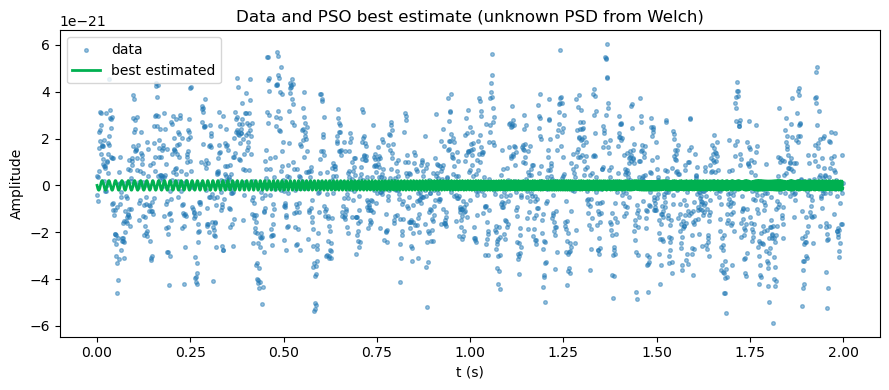

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import welch

from glrtqcsig4pso import glrtqcsig4pso      # 我们写过的 GLRT 适应度（默认返回 -GLRT）
from crcbpso import crcbpso                  # 你的 PSO
from glrtcalc import innerprodpsd            # 与前面一致的 PSD 内积

# ---------- 1) 读取数据 ----------
an = loadmat("analysisData.mat", squeeze_me=True)
tr = loadmat("TrainingData.mat", squeeze_me=True)

y  = np.asarray(an["dataVec"],  dtype=float).ravel()
fs = float(an["sampFreq"])
noise_train = np.asarray(tr["trainData"], dtype=float).ravel()

N  = y.size
t  = np.arange(N) / fs

# ---------- 2) Welch 估计训练噪声的 one-sided PSD，并映射到 y 的 rFFT 网格 ----------
#   welch 返回的是功率谱密度 [power/Hz]，one-sided，频率 [0..fs/2]
fw, Pxx = welch(noise_train, fs=fs, nperseg=2048, noverlap=1024, scaling="density")
#   将 PSD 插值到分析数据的正频 DFT 网格（长度 N//2+1）
fpos = np.fft.rfftfreq(N, 1/fs)
psd_on_bins = np.interp(fpos, fw, Pxx, left=Pxx[0], right=Pxx[-1])
psd_on_bins = np.maximum(psd_on_bins, 1e-16*np.median(psd_on_bins))  # 防 0

# ---------- 3) 组装 PSO 适应度所需的参数包 ----------
P = {
    "dataY":      y,
    "dataX":      t,
    "fs":         fs,
    "psdPosFreq": psd_on_bins,
    "dataXSq":    t**2,            # 可选缓存（加速）
    "dataXCb":    t**3,
    # 搜索范围（标准化坐标会按 rmin/rmax 映射到真实参数）
    # 这组范围与课件一致；若你有先验可收紧范围以加速收敛
    "rmin": np.array([ 40.0,  1.0,  11.0]),
    "rmax": np.array([100.0, 50.0, 15.0]),
}

# ---------- 4) 多次独立 PSO 运行，取最优 ----------
pso_params = {
    "popSize":   80,
    "maxSteps":  1000,
    # 需要可以加：'c1','c2','startInertia','endInertia','maxVelocity','nbrhdSz' 等
}
M = 8  # 独立运行次数

best_val = np.inf
best_loc = None
best_seed = None

for seed in range(1, M+1):
    rng = np.random.default_rng(seed)
    # PSO 适应度：glrtqcsig4pso 默认返回 -GLRT（我们需要最小化）
    res = crcbpso(lambda X: glrtqcsig4pso(X, P), 3, p=pso_params, rng=rng)
    if res["bestFitness"] < best_val:
        best_val = res["bestFitness"]
        best_loc = res["bestLocation"].copy()
        best_seed = seed

# 把标准化坐标映射为真实参数
rmin, rmax = P["rmin"], P["rmax"]
a1, a2, a3 = rmin + best_loc * (rmax - rmin)
print(f"Best run seed: {best_seed}")
print(f"Best fitness (=-GLRT): {best_val}")
print(f"Best [a1, a2, a3]: [{a1:.6f}  {a2:.6f}  {a3:.6f}]")

# ---------- 5) 用最优参数重建 PSD 单位范数模板，估计幅度（=匹配滤波 SNR） ----------
phase = a1*t + a2*t**2 + a3*t**3
s = np.sin(2*np.pi*phase)
nrm2 = innerprodpsd(s, s, fs, psd_on_bins)
q = s / np.sqrt(max(nrm2, 1e-18))                 # PSD 内积下单位范数模板
A_hat = innerprodpsd(y, q, fs, psd_on_bins)       # 幅度估计（也就是 SNR）
estSig = A_hat * q

print(f"Estimated SNR (amplitude): {A_hat:.3f}")

# ---------- 6) 画图 ----------
plt.figure(figsize=(9,4))
plt.scatter(t, y, s=7, alpha=0.45, label="data")
plt.plot(t, estSig, lw=2.0, color=(0/255, 176/255, 80/255), label="best estimated")
plt.xlabel("t (s)"); plt.ylabel("Amplitude")
plt.title("Data and PSO best estimate (unknown PSD from Welch)")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# 取你刚跑出来的最优参数 a1,a2,a3
phase = a1*t + a2*t**2 + a3*t**3
s     = np.sin(2*np.pi*phase)
q_est = s / np.sqrt(max(innerprodpsd(s, s, fs, psd_on_bins), 1e-18))

llr   = innerprodpsd(y, q_est, fs, psd_on_bins)
glrt  = llr**2

print("Consistency: GLRT_from_innerprod  =", glrt)
print("Consistency: -best_fitness (PSO)  =", -best_val)


Consistency: GLRT_from_innerprod  = 73904807.81761307
Consistency: -best_fitness (PSO)  = 73904807.81761307


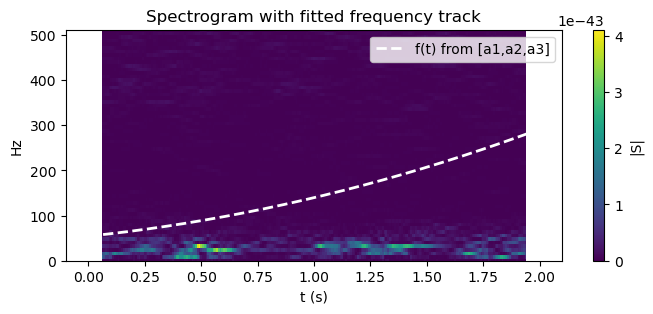

In [4]:
from scipy.signal import spectrogram

f, tt, Sxx = spectrogram(y, fs=fs, nperseg=128, noverlap=120)
plt.figure(figsize=(8,3))
plt.pcolormesh(tt, f, np.abs(Sxx), shading="auto")
plt.ylim(0, fs/2)
plt.colorbar(label="|S|")
plt.plot(t, a1 + 2*a2*t + 3*a3*t*t, "w--", lw=2, label="f(t) from [a1,a2,a3]")
plt.legend(); plt.xlabel("t (s)"); plt.ylabel("Hz")
plt.title("Spectrogram with fitted frequency track")
plt.show()